In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

<module 'matplotlib.pyplot' from 'C:\\Users\\kostyad\\AppData\\Local\\Continuum\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

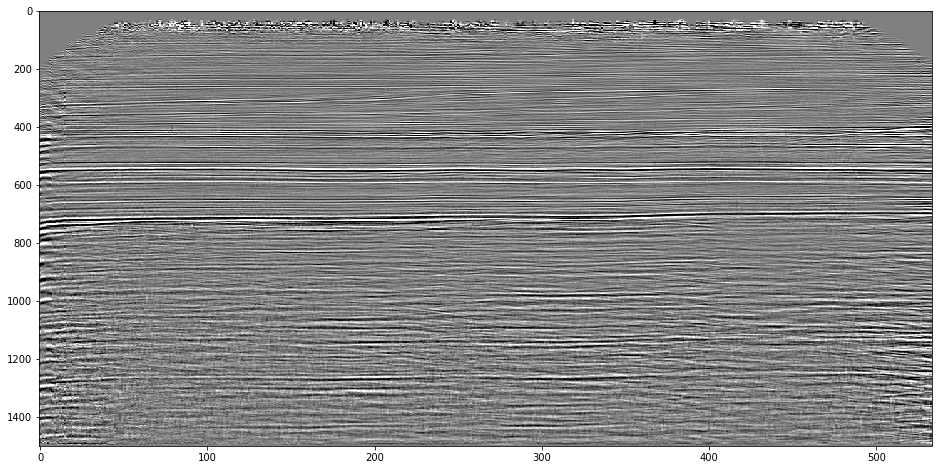

In [2]:
from seismic_handler import SeismicPrestack

handler = SeismicPrestack ('data/31_81_PR.sgy')
parts = handler.readGatherParts (10000, 10000)
data = parts[0]

handler.plot(data)

<module 'matplotlib.pyplot' from 'C:\\Users\\kostyad\\AppData\\Local\\Continuum\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

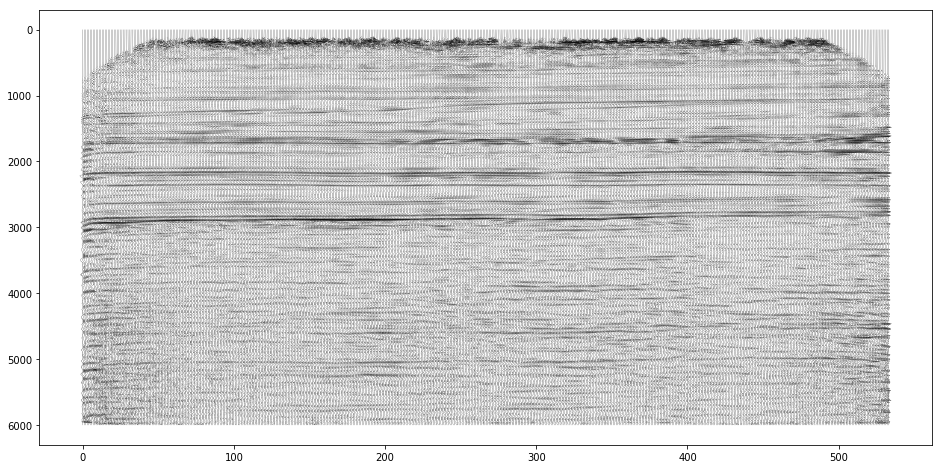

In [3]:
handler.wiggle_plot(data)

<module 'matplotlib.pyplot' from 'C:\\Users\\kostyad\\AppData\\Local\\Continuum\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

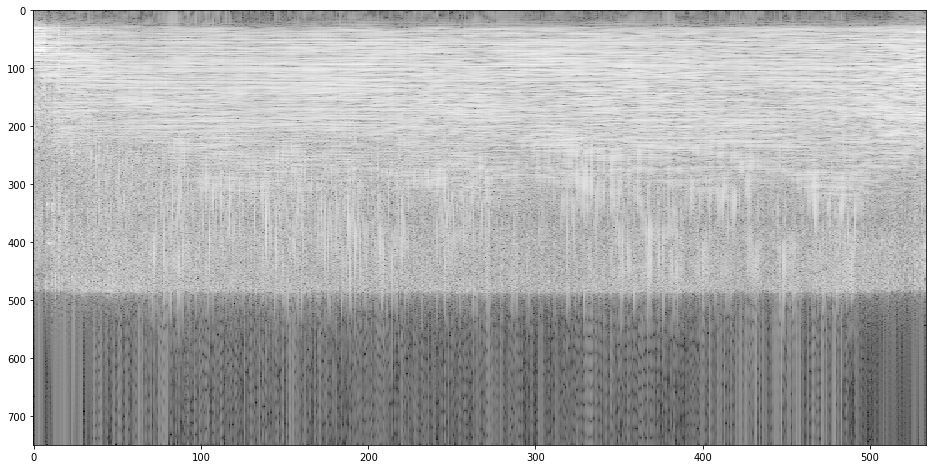

In [4]:
db_matrix = handler.spectrogram (data)

handler.plot_spec(db_matrix.T)

<module 'matplotlib.pyplot' from 'C:\\Users\\kostyad\\AppData\\Local\\Continuum\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

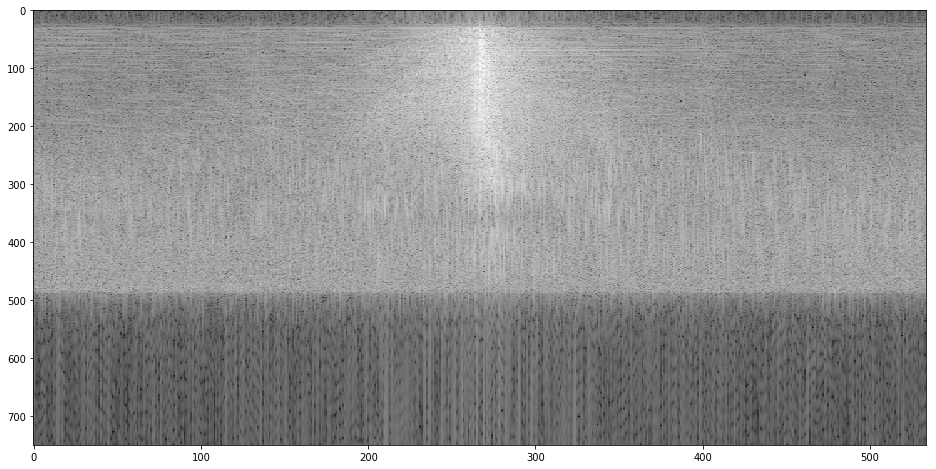

In [5]:
fk_spec = handler.fk (data)

handler.plot_spec(fk_spec)

prepare images

In [6]:
handler = SeismicPrestack ('data/31_81_PR.sgy')
parts = handler.readGatherParts (50, 0.4)

In [ ]:
#image = convert_to_image (parts[0].T)
#image.save ('images/data/test.png')

In [ ]:
import os

images_dir = 'images/'

#if os.path.exists(images_dir):
#    import shutil
#    shutil.rmtree(images_dir)

if not os.path.exists(images_dir):
    os.makedirs(images_dir)

data_images_dir = images_dir + '/data/'
if not os.path.exists(data_images_dir):
    os.makedirs(data_images_dir)

counter = 0
for data in parts:
    #plt = SeismicPrestack.plot(data)
    png_name = data_images_dir + str(counter) + '.png'
    #plt.savefig(png_name, bbox_inches='tight', pad_inches=0.0)
    #plt.close()
    image = SeismicPrestack.convert_to_image (data.T)
    image.save (png_name)
    counter = counter+1

TF

In [ ]:
def train ():
    from keras import backend as K
    from keras.models import Sequential
    from keras.layers.core import Flatten, Dense, Dropout, Activation
    from keras.optimizers import rmsprop
    from keras.models import Sequential
    from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
    from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D
    from keras.callbacks import EarlyStopping, ModelCheckpoint
    from keras.layers import Input, Dense
    import os
    import numpy as np
    import pandas as pd
    import numpy as np
    import pickle

    # Set values

    num_classes = 9
    image_size = 256
    nb_epoch = 20
    batch_size = 128

    train_data_dir = 'data/train'
    validation_data_dir = 'data/validation'

    nb_train_samples = 120000
    nb_validation_samples = 42000

    if K.image_data_format() == 'channels_first':
        input_shape = (3, image_size, image_size)
    else:
        input_shape = (image_size, image_size, 3)

    # Specify model

    # callbacks
    early_stopping = EarlyStopping(monitor='val_loss', patience=3)
    save_best_model = ModelCheckpoint(filepath='model_.{epoch:02d}_{val_loss:.2f}.hdf5', verbose=1,
            monitor='val_loss')

    # instantiate Sequential model
    model = Sequential()

    model.add(Conv2D(filters=64, kernel_size=2, strides=2, activation='elu', kernel_initializer='glorot_normal', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=2, padding='same'))

    model.add(Conv2D(filters=128, kernel_size=2, strides=2, activation='elu', kernel_initializer='glorot_normal'))
    model.add(MaxPooling2D(pool_size=2, padding='same'))

    model.add(Conv2D(filters=256, kernel_size=2, strides=2, activation='elu', kernel_initializer='glorot_normal'))
    model.add(MaxPooling2D(pool_size=2, padding='same'))

    model.add(Conv2D(filters=512, kernel_size=2, strides=2, activation='elu', kernel_initializer='glorot_normal'))
    model.add(MaxPooling2D(pool_size=2, padding='same'))

    model.add(Flatten())
    model.add(Dense(128))

    model.add(Activation('elu'))
    model.add(Dropout(0.5))

    model.add(Dense(num_classes))
    model.add(Activation('softmax'))
    opt = rmsprop()

    model.compile(loss='categorical_crossentropy',
                 optimizer = opt,
                 metrics = ['accuracy'])

    # Image generators
    train_datagen = ImageDataGenerator(rescale= 1./255)
    validation_datagen = ImageDataGenerator(rescale=1./255)

    train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(image_size, image_size),
        shuffle=True,
        batch_size=batch_size,
        class_mode='categorical'
        )

    validation_generator = validation_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(image_size, image_size),
        batch_size=batch_size,
        shuffle=True,
        class_mode='categorical'
        )

    # Fit model
    history = model.fit_generator(train_generator,
                        steps_per_epoch=(nb_train_samples // batch_size),
                        epochs=nb_epoch,
                        validation_data=validation_generator,
                        callbacks=[early_stopping, save_best_model],
                        validation_steps=(nb_validation_samples // batch_size)
                       )

    # Save model
    model.save_weights('full_model_weights.h5')
    model.save('model.h5')